I have filtered out the csv file to only include what is relevant to us which are the video IDs and their respective annotations. Since there were issues with the API trying to extract thumbnails of the video, we were able to get 783 rows in the csv but 785 images, so i have deleted the extra 2 images as well.

In [67]:
import pandas as pd
import os

# Assuming the CSV file is named 'all_results_sample.csv' and the folder containing images is mounted from Google Drive and named 'output'
csv_file = 'all_results_sample.csv'
image_folder = '/content/drive/MyDrive/output'

# Load CSV file into a DataFrame
annotations_df = pd.read_csv(csv_file)

# Extract video IDs from the 'vid_url' column
annotations_df['video_id'] = annotations_df['vid_url'].str.extract(r'(?<=v=)([\w-]+)')

# Create a new DataFrame 'id_df' with just the 'video_id' column
# Drop all columns except 'video_id' and 'annotations'
annotations_df = annotations_df[['video_id', 'normalized_annotation']].copy()

# Get a list of image names from the folder
image_names = os.listdir(image_folder)

# # Remove the '.jpg' extension from image names
image_names_without_extension = [name.replace('.jpg', '') for name in image_names]
# print(image_names_without_extension)
print(len(image_names_without_extension))

filtered_annotations_df = annotations_df[annotations_df['video_id'].isin(image_names_without_extension)]
filtered_annotations_df

# Keep only unique values of 'video_id' in filtered_annotations_df
filtered_annotations_df = filtered_annotations_df.drop_duplicates(subset=['video_id'])

# Get the list of unique video IDs in filtered_annotations_df
unique_video_ids = filtered_annotations_df['video_id'].unique()

# Now filtered_annotations_df contains only unique values of 'video_id'
# Get the list of image names to delete
images_to_delete = [name + '.jpg' for name in image_names_without_extension if name not in unique_video_ids]

# Delete the images from the folder
for image_name in images_to_delete:
    image_path = os.path.join(image_folder, image_name)
    os.remove(image_path)

print(f"Deleted {len(images_to_delete)} images from the folder.")

783
Deleted 0 images from the folder.


In [69]:
# Path to save the final CSV file
output_csv_file = 'filtered_annotations.csv'

# Save the final DataFrame to a CSV file
filtered_annotations_df.to_csv(output_csv_file, index=False)

print(f"Filtered annotations saved to {output_csv_file}.")

Filtered annotations saved to filtered_annotations.csv.


Pair images with their respective annotations with video_id as the common link, handle X and Y, split into train, test and val, convert the list(X & Y) to np array as that is what the NN would understand



In [71]:
import cv2
data = []
for index, row in filtered_annotations_df.iterrows():
    video_id = row['video_id']
    annotation = row['normalized_annotation']
    image_index = image_names_without_extension.index(video_id)
    image_path = os.path.join(image_folder, image_names[image_index])
    image = cv2.imread(image_path)  # Read image using OpenCV
    data.append((image, annotation))

In [72]:
data_size = len(data)
print("Size of the data:", data_size)

Size of the data: 783


In [80]:
# Separate X and Y from data
X = [item[0] for item in data]  # Extract images from the tuples
Y = [item[1] for item in data]  # Extract annotations from the tuples

In [81]:
# Convert labels from -1, 0, 1 to 0, 1, 2
Y = [label + 1 for label in Y]

In [82]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [83]:
import numpy as np

# Convert lists to NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

Epoch 1/20
16/16 [==============================] - 18s 1s/step - loss: 14834.9492 - accuracy: 0.4400 - val_loss: 7186.3491 - val_accuracy: 0.6111
Epoch 2/20
16/16 [==============================] - 16s 1s/step - loss: 4650.5864 - accuracy: 0.4760 - val_loss: 2943.6956 - val_accuracy: 0.2619
Epoch 3/20
16/16 [==============================] - 16s 1s/step - loss: 2767.7617 - accuracy: 0.4700 - val_loss: 1989.2726 - val_accuracy: 0.3175
Epoch 4/20
16/16 [==============================] - 16s 1s/step - loss: 1015.5233 - accuracy: 0.5500 - val_loss: 1766.9109 - val_accuracy: 0.3492
Epoch 5/20
16/16 [==============================] - 16s 1s/step - loss: 1136.7269 - accuracy: 0.5400 - val_loss: 2509.9851 - val_accuracy: 0.2857
Epoch 6/20
16/16 [==============================] - 16s 1s/step - loss: 2061.3630 - accuracy: 0.5240 - val_loss: 1884.1366 - val_accuracy: 0.5873
Epoch 7/20
16/16 [==============================] - 16s 1s/step - loss: 1494.2811 - accuracy: 0.5520 - val_loss: 1273.0480 

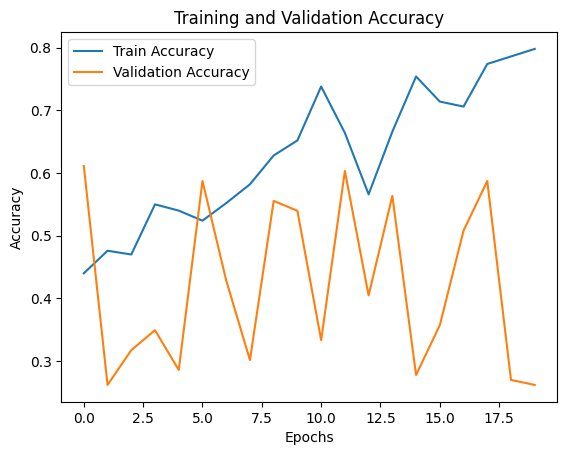

5/5 [==============================] - 1s 98ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.08      0.11        50
           1       0.58      0.33      0.42        84
           2       0.18      0.70      0.29        23

    accuracy                           0.31       157
   macro avg       0.32      0.37      0.27       157
weighted avg       0.40      0.31      0.31       157

Average Accuracy: 0.3057324840764331


In [84]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(320, 320, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # Output layer with 3 units for 3 classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for multi-class classification
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val))

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(Y_test, y_pred_classes))
print("Average Accuracy:", accuracy_score(Y_test, y_pred_classes))


Epoch 1/20
16/16 [==============================] - 35s 2s/step - loss: 5387.6172 - accuracy: 0.2140 - val_loss: 1482.4214 - val_accuracy: 0.6190
Epoch 2/20
16/16 [==============================] - 29s 2s/step - loss: 1897.1071 - accuracy: 0.3920 - val_loss: 507.4158 - val_accuracy: 0.5794
Epoch 3/20
16/16 [==============================] - 31s 2s/step - loss: 1008.6161 - accuracy: 0.3760 - val_loss: 964.1826 - val_accuracy: 0.3016
Epoch 4/20
16/16 [==============================] - 29s 2s/step - loss: 643.8588 - accuracy: 0.5280 - val_loss: 355.0110 - val_accuracy: 0.6032
Epoch 5/20
16/16 [==============================] - 30s 2s/step - loss: 220.4605 - accuracy: 0.4340 - val_loss: 325.0457 - val_accuracy: 0.2698
Epoch 6/20
16/16 [==============================] - 30s 2s/step - loss: 20.4540 - accuracy: 0.5680 - val_loss: 1.0834 - val_accuracy: 0.6190
Epoch 7/20
16/16 [==============================] - 30s 2s/step - loss: 1.2210 - accuracy: 0.5860 - val_loss: 1.0906 - val_accuracy: 0.

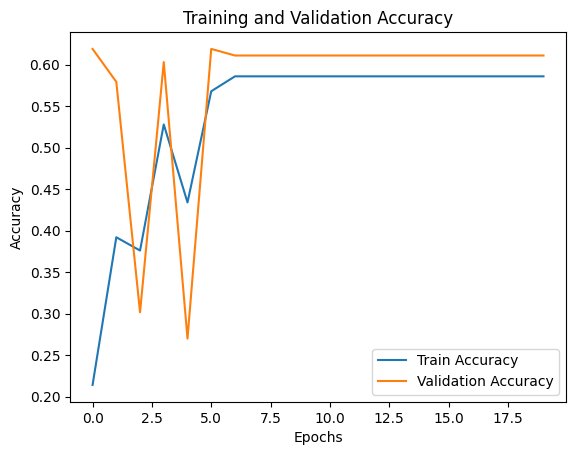

5/5 [==============================] - 1s 174ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        50
           1       0.54      1.00      0.70        84
           2       0.00      0.00      0.00        23

    accuracy                           0.54       157
   macro avg       0.18      0.33      0.23       157
weighted avg       0.29      0.54      0.37       157

Average Accuracy: 0.535031847133758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [85]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(320, 320, 3)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for multi-class classification
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val))

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("Classification Report:")
print(classification_report(Y_test, y_pred_classes))
print("Average Accuracy:", accuracy_score(Y_test, y_pred_classes))